# Artificial Intelligence CEP  
### 8 Queens Problem Solver  
**Submitted by:**  
- Moiz Haider (CS-23137)  
- Sufyan Ali (CS-23134)
- Mohammad Zain (CS-23099)

**Submitted To:** Dr. Maria Waqas  
 
---

### Objective:
Solve the 8-Queens problem using two different AI approaches:  
1. Local Search (Min-Conflicts or Hill Climbing)  
2. Constraint Satisfaction Problem (CSP) using Backtracking with heuristics  

---



In [ ]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt


# GLOBAL BOARD SIZE
N = int(input("Enter value for N: ")) #----> N-queens generalization



## Problem Definition

**8 Queens Problem:**  
Place 8 queens on a chessboard such that no two queens attack each other.  
Queens attack along:
- Same **row**
- Same **column**
- Same **diagonal**

---

### State Representation:
We represent the board as a *list of length N* where each index represents a column,  
and the value represents the row of the queen in that column.

Example:


In [5]:
def generate_random_state(n: int = None) -> list:
    """Generate a random board with one queen per column."""
    if n is None:
        n = N
    return [random.randrange(n) for _ in range(n)]


def conflicts(state: list) -> int:
    """Count number of conflicting pairs of queens."""
    n = len(state)
    count = 0
    for i in range(n):
        for j in range(i + 1, n):
            # same row OR same diagonal
            if state[i] == state[j] or abs(state[i] - state[j]) == abs(i - j):
                count += 1
    return count


def display_board(state):
    """
    Display the board with queens.
    Queens in conflict are shown in RED.
    Non-conflicting queens are shown in BLACK.
    """
    n = len(state)
    fig, ax = plt.subplots(figsize=(6, 6))

    #  Draw grid
    for r in range(n):
        for c in range(n):
            ax.add_patch(plt.Rectangle((c, r), 1, 1, fill=False))

    #  Draw queens (with conflict detection)
    for col, row in enumerate(state):
        conflict = False
        for c2, r2 in enumerate(state):
            if c2 != col:
                # Same row OR same diagonal → conflict
                if r2 == row or abs(r2 - row) == abs(c2 - col):
                    conflict = True
                    break

        color = "red" if conflict else "black"

        ax.text(col + 0.5, row + 0.5, "♛",
                color=color, fontsize=30,
                ha='center', va='center')

    # Formatting
    ax.set_xlim(0, n)
    ax.set_ylim(0, n)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()
    plt.show()

Random State: [2, 9, 13, 12, 1, 0, 15, 5, 14, 12, 6, 3, 12, 6, 1, 1]
Conflicts: 14


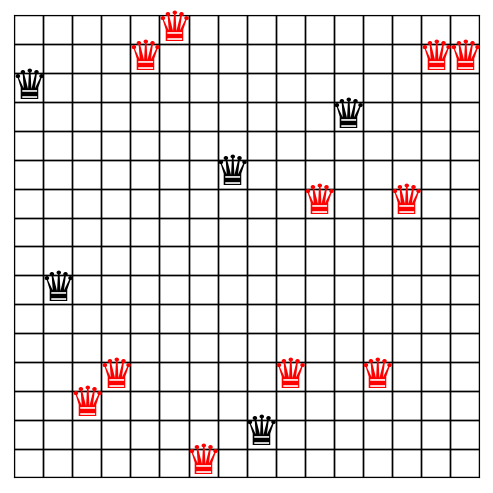

In [6]:
state = generate_random_state()   # <-- NO HARD CODED 8
print("Random State:", state)
print("Conflicts:", conflicts(state))
display_board(state)



## Algorithm 1: Hill-Climbing (Local Search)

**Idea:**  
Start from a random board and iteratively move towards a better (lower-conflict) board  
by changing the position of queens one by one.

If no better move is possible, we may be stuck in a **local minimum** (not global best).  
To overcome that, we perform **random restarts** — i.e., start again from a new random board.

---

### Steps:
1. Start with a random arrangement of queens.
2. Calculate total number of conflicts.
3. For every possible single move (move one queen to another row in its column):
   - Check if conflicts decrease.
4. Move to the state with **minimum conflicts**.
5. If no improvement → local minimum → restart randomly.
6. Continue until solution found or maximum restarts reached.

### Characteristics:
- **Type:** Local search (uses heuristic = number of conflicts)
- **Completeness:** No (can get stuck)
- **Optimality:** No
- **Efficiency:** Very fast for small boards like 8-Queens


In [27]:
def hill_climbing(max_restarts=50, n=None):
    """
    Hill-Climbing with Random Restarts for N-Queens.
    Uses global N if n is not provided.
    """
    if n is None:
        n = N   # <-- use global board size

    def best_neighbor(state):
        """Generate the best neighbor with lowest conflicts."""
        best = state[:]
        best_conf = conflicts(state)

        for col in range(n):
            for row in range(n):
                if row != state[col]:  # skip same row
                    new_state = state[:]
                    new_state[col] = row
                    new_conf = conflicts(new_state)
                    if new_conf < best_conf:
                        best, best_conf = new_state, new_conf
        return best, best_conf
    
    for restart in range(max_restarts):
        state = generate_random_state(n)  # uses dynamic n
        current_conf = conflicts(state)
        
        while True:
            neighbor, neighbor_conf = best_neighbor(state)
            
            if neighbor_conf >= current_conf:  # no improvement
                break
            
            state = neighbor
            current_conf = neighbor_conf
            
            if current_conf == 0:              # found solution
                return state, True, restart
    
    return state, False, max_restarts


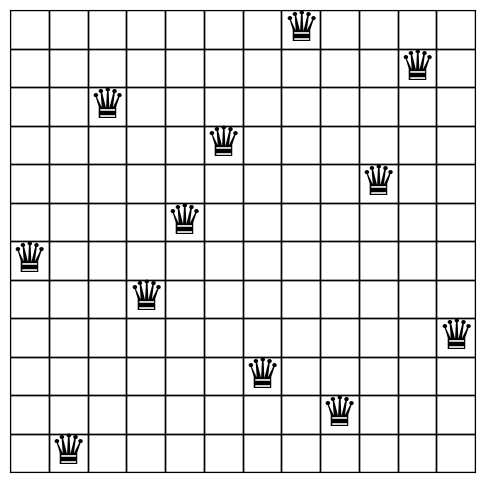

Hill-Climbing Result:
Success: True
Restarts used: 21
Conflicts in final board: 0


In [28]:
# =====================================================
# Test: Hill-Climbing with Random Restarts (GLOBAL N)
# =====================================================

solution, success, restarts_used = hill_climbing(max_restarts=100)

display_board(solution)
print("Hill-Climbing Result:")
print("Success:", success)
print("Restarts used:", restarts_used)
print("Conflicts in final board:", conflicts(solution))


## Algorithm 2: Constraint Satisfaction (Backtracking + MRV + Forward Checking)

### Problem as CSP
- **Variables:** 8 columns (each column must have exactly 1 queen)
- **Domains:** Rows 0–7
- **Constraints:** No two queens attack each other

### Approach:
1. Assign queens column by column.
2. Use **MRV** to pick the next column with the fewest valid positions.
3. Apply **Forward Checking** after each assignment to prune invalid rows in remaining columns.
4. If a dead end occurs → backtrack to previous column.
5. Continue until all 8 queens are safely placed (solution) or all options exhausted.

### Characteristics:
- **Type:** Systematic (CSP)
- **Completeness:** Yes (guaranteed to find a solution)
- **Optimality:** Not relevant (any valid board works)
- **Heuristic:** MRV (choose variable with fewest options)


In [29]:
def is_safe(assignment, col, row):
    """Check if placing a queen at (col, row) is safe given current assignment."""
    for c, r in assignment.items():
        # same row or same diagonal = conflict
        if r == row or abs(r - row) == abs(c - col):
            return False
    return True


def get_unassigned_var(variables, domains):
    """Return variable with Minimum Remaining Values (MRV)."""
    unassigned = [v for v in variables if v not in domains["assigned"]]
    if not unassigned:
        return None
    # variable with smallest domain size
    return min(unassigned, key=lambda var: len(domains[var]))


def forward_check(domains, col, row, n=None):
    """Perform forward checking: remove conflicting rows from future domains."""
    
    if n is None:
        n = N   # ← use global N if not provided

    # deep copy domains
    new_domains = {v: set(domains[v]) for v in domains if v != "assigned"}
    new_domains["assigned"] = domains["assigned"].copy()

    # mark this variable as assigned
    new_domains["assigned"].add(col)

    # prune future columns
    for future_col in range(col + 1, n):
        if future_col in new_domains:
            for r in list(new_domains[future_col]):
                if r == row or abs(r - row) == abs(future_col - col):
                    new_domains[future_col].discard(r)

    return new_domains


def backtrack_csp(assignment, domains, n=None):
    """Recursive Backtracking CSP solver with MRV and Forward Checking."""
    
    if n is None:
        n = N   # ← use global N

    # goal condition
    if len(assignment) == n:
        return assignment

    # choose next variable using MRV
    var = get_unassigned_var(range(n), domains)
    if var is None:
        return None

    # try assigning each possible row
    for value in sorted(domains[var]):
        if is_safe(assignment, var, value):
            assignment[var] = value

            # forward checking
            new_domains = forward_check(domains, var, value, n)

            # recursive solving
            result = backtrack_csp(assignment.copy(), new_domains, n)
            if result:
                return result

            # backtrack
            del assignment[var]

    return None


def solve_csp(n=None):
    """Wrapper for CSP with MRV + Forward Checking."""
    
    if n is None:
        n = N  # ← global N

    # initial domain: all rows available
    domains = {col: set(range(n)) for col in range(n)}
    domains["assigned"] = set()

    assignment = {}
    return backtrack_csp(assignment, domains, n)


CSP Solution found!
State (column -> row): {0: 0, 1: 2, 2: 4, 5: 9, 6: 11, 7: 3, 9: 6, 10: 8, 8: 1, 11: 5, 3: 10, 4: 7}


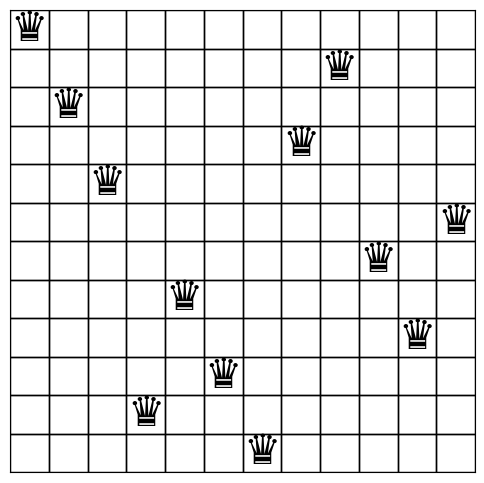

Conflicts: 0


In [30]:
# =====================================================
# Test: CSP Backtracking with MRV + Forward Checking (GLOBAL N)
# =====================================================

solution = solve_csp()

if solution:
    print("CSP Solution found!")
    print("State (column -> row):", solution)
    state = [solution[i] for i in range(N)]
    display_board(state)
    print("Conflicts:", conflicts(state))
else:
    print("No solution found.")


# Performance Comparison of Both Algorithms

We compare:
1. **Hill-Climbing (Local Search)**
2. **CSP Backtracking with MRV + Forward Checking**

### Metrics used:
- **Runtime (seconds)**
- **Success Rate**
- **Restarts required** (Hill-Climbing only)
- **Conflicts** (should be 0)
- **Steps taken** (Min-Conflicts/Hill-Climb)


In [31]:
import time

def time_function(func, *args):
    """Measure runtime of any solver function."""
    start = time.time()
    result = func(*args)
    end = time.time()
    return result, end - start


In [32]:
import numpy as np

def evaluate_algorithms(runs=20):
    hc_success = 0
    hc_times = []
    hc_restarts = []

    csp_success = 0
    csp_times = []

    for i in range(runs):
        # --- Hill Climbing ---
        (solution, success, restarts), t = time_function(hill_climbing, 50, 8)
        hc_times.append(t)
        hc_restarts.append(restarts)
        if success and conflicts(solution) == 0:
            hc_success += 1

        # --- CSP ---
        solution_csp, t2 = time_function(solve_csp, 8)
        csp_times.append(t2)
        if solution_csp and conflicts([solution_csp[x] for x in range(8)]) == 0:
            csp_success += 1

    return {
        "hc_success": hc_success,
        "hc_times": hc_times,
        "hc_restarts": hc_restarts,
        "csp_success": csp_success,
        "csp_times": csp_times
    }

results = evaluate_algorithms(20)
print("Done running experiments!")


Done running experiments!


In [33]:
print("===== HILL CLIMBING RESULTS =====")
print("Success:", results['hc_success'], "/ 20")
print("Average Time:", np.mean(results['hc_times']))
print("Average Restarts:", np.mean(results['hc_restarts']))

print("\n===== CSP RESULTS =====")
print("Success:", results['csp_success'], "/ 20")
print("Average Time:", np.mean(results['csp_times']))


===== HILL CLIMBING RESULTS =====
Success: 20 / 20
Average Time: 0.0818718671798706
Average Restarts: 4.25

===== CSP RESULTS =====
Success: 20 / 20
Average Time: 0.009734070301055909


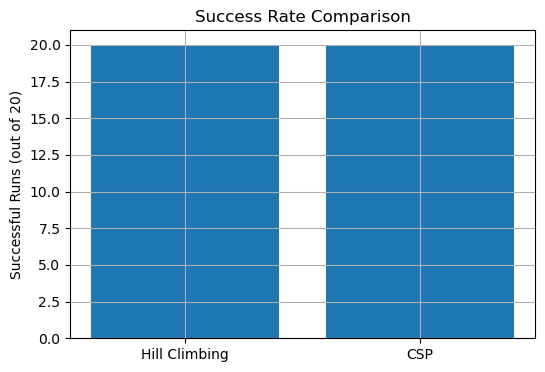

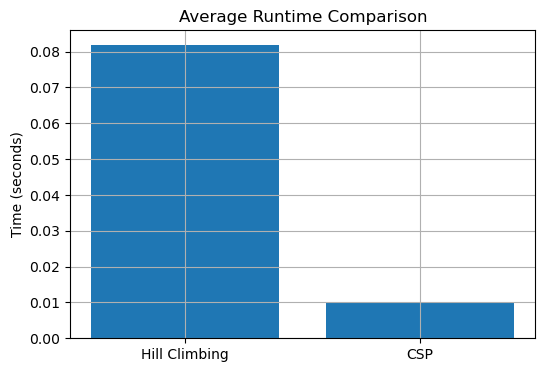

In [34]:
import matplotlib.pyplot as plt

# Success Rate Graph
plt.figure(figsize=(6,4))
plt.bar(["Hill Climbing", "CSP"], 
        [results['hc_success'], results['csp_success']])
plt.title("Success Rate Comparison")
plt.ylabel("Successful Runs (out of 20)")
plt.show()

# Runtime Graph
plt.figure(figsize=(6,4))
plt.bar(["Hill Climbing", "CSP"], 
        [np.mean(results['hc_times']), np.mean(results['csp_times'])])
plt.title("Average Runtime Comparison")
plt.ylabel("Time (seconds)")
plt.show()


###  Interpretation of Results

- **Hill-Climbing**:
  - Fastest algorithm.
  - But sometimes gets stuck in local minima.
  - Not guaranteed to solve 8 queens every time.
  - Needs random restarts.

- **CSP Backtracking (MRV + Forward Checking)**:
  - Slower than hill-climbing.
  - But success rate = 100% (always finds a valid board).
  - More stable and systematic because it prunes invalid states.

### Final Conclusion:
Hill-Climbing is very efficient but incomplete,  
whereas CSP is complete and reliable but slightly slower.
